### Notebook for running SCOT on scGEM Data

Below, we replicate our results for the scGEM dataset reported in ["Gromov-Wasserstein optimal transport to align single-cell multi-omics data"](https://www.biorxiv.org/content/10.1101/2020.04.28.066787v2). 

If you have any questions, e-mail: ritambhara@brown.edu, pinar_demetci@brown.edu, rebecca_santorella@brown.edu  

**Access to the dataset:** The dataset was originally generated by Cheow et al, reported in the paper ["Single-cell multimodal profiling reveals cellular epigenetic heterogeneity."](https://www.nature.com/articles/nmeth.3961). This dataset contains cells from BJ cell line (human fibroblast cells), differentiating into iPS cells (pluripotent stem cells). We access the pre-processed version stored in https://github.com/jw156605/MATCHER/tree/master/pymatcher/data. 

In [1]:
import sys
sys.path.insert(1, '../src/')
from scot import *

In [2]:
X=np.genfromtxt("../data/scGEM_expression.csv", delimiter=",")
y=np.genfromtxt("../data/scGEM_methylation.csv", delimiter=",")
print("Dimensions of input datasets are: ", "X= ", X.shape, " y= ", y.shape)

Dimensions of input datasets are:  X=  (177, 34)  y=  (177, 27)


In [3]:
# initialize SCOT object
scot=SCOT(X, y)
# call the alignment with l2 normalization 
# A hyperparameter combination that yields the best result we've obtained (FOSCTTM ~0.2) is below:
X_new, y_new = scot.align( k=35, e=5e-3,  normalize=True, norm="l2")

It.  |Err         
-------------------
    0|5.587079e-03|


/Users/thnguy22/anaconda3/lib/python3.10/site-packages/ot/bregman.py:535: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


   10|7.742085e-05|
   20|6.302987e-06|
   30|7.716979e-07|
   40|9.942365e-08|
   50|1.301199e-08|
   60|1.712421e-09|
   70|2.258149e-10|


### Evaluating Alignment

In [4]:
import evals 

# We will use the average FOSCTTM measure implemented in evals.py for evaluation (metric used in the publication Demetci et al 2021)
# This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples. 
fracs=evals.calc_domainAveraged_FOSCTTM(X_new, y_new)
print("Average FOSCTTM score for this alignment with X onto Y is: ", np.mean(fracs))

Average FOSCTTM score for this alignment with X onto Y is:  0.1918817411402157


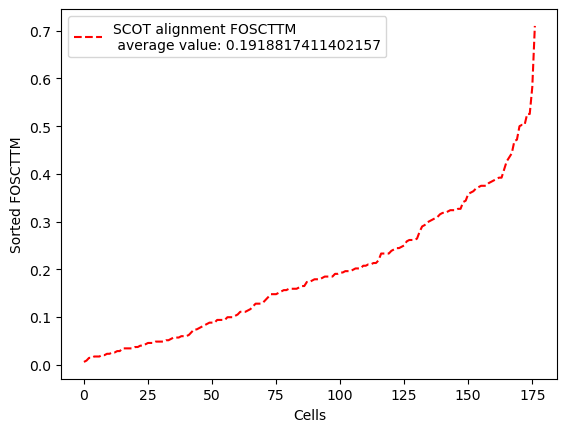

In [5]:
import matplotlib.pyplot as plt
legend_label="SCOT alignment FOSCTTM \n average value: "+str(np.mean(fracs))
plt.plot(np.arange(len(fracs)), np.sort(fracs), "r--", label=legend_label)
plt.legend()
plt.xlabel("Cells")
plt.ylabel("Sorted FOSCTTM")
plt.show()

### Visualizing Alignment

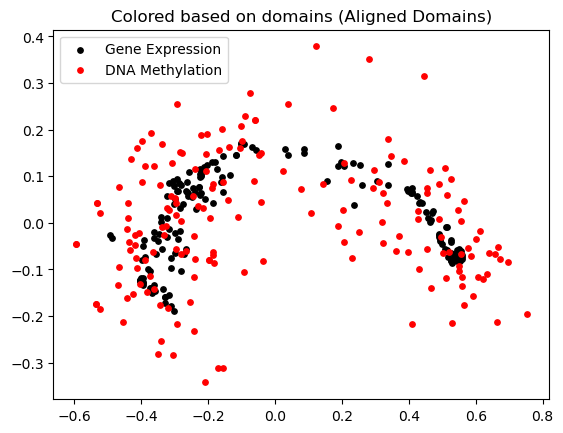

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Reduce the dimensionality of the aligned domains to two (2D) via PCA for the sake of visualization:

pca=PCA(n_components=2)
Xy_pca=pca.fit_transform(np.concatenate((X_new, y_new), axis=0))
X_pca=Xy_pca[0: 177,]
y_pca=Xy_pca[177:,]


#Plot aligned domains, samples colored by domain identity:
plt.scatter(X_pca[:,0], X_pca[:,1], c="k", s=15, label="Gene Expression")
plt.scatter(y_pca[:,0], y_pca[:,1], c="r", s=15, label="DNA Methylation")
plt.legend()
plt.title("Colored based on domains (Aligned Domains)")
plt.show()

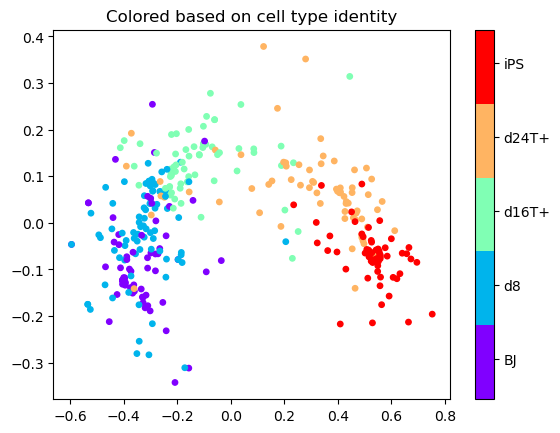

In [7]:
#Plot aligned domains, samples colored by cell types:
cellTypes_rna=np.loadtxt("../data/scGEM_typeExpression.txt")
cellTypes_methyl=np.loadtxt("../data/scGEM_typeMethylation.txt")

colormap = plt.get_cmap('rainbow', 5) 
plt.scatter(X_pca[:,0], X_pca[:,1], c=cellTypes_rna, s=15, cmap=colormap)
plt.scatter(y_pca[:,0], y_pca[:,1], c=cellTypes_methyl, s=15, cmap=colormap)
cbar=plt.colorbar()

# approximately center the colors on the colorbar when adding cell type labels
tick_locs = (np.arange(1,6)+0.8) *4/5 
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["BJ", "d8", "d16T+", "d24T+", "iPS"]) #cell-type labels
plt.title("Colored based on cell type identity")
plt.show()


#### Compare alignment visualization with the original domains *before* the alignment

Text(0.5, 1.0, 'Gene Expression Domain \n *before* Alignment')

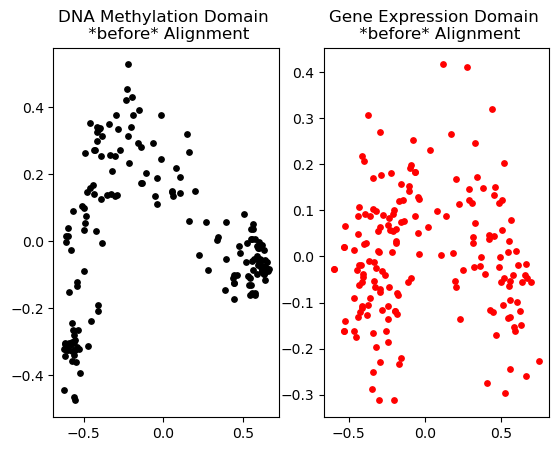

In [8]:
originalX_pca=pca.fit_transform(normalize(X))
originaly_pca=pca.fit_transform(normalize(y))

#Visualization of the global geometry
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c="k", s=15)
ax1.set_title("DNA Methylation Domain \n *before* Alignment")
ax2.scatter(originaly_pca[:,0], originaly_pca[:,1], c="r", s=15)
ax2.set_title("Gene Expression Domain \n *before* Alignment")

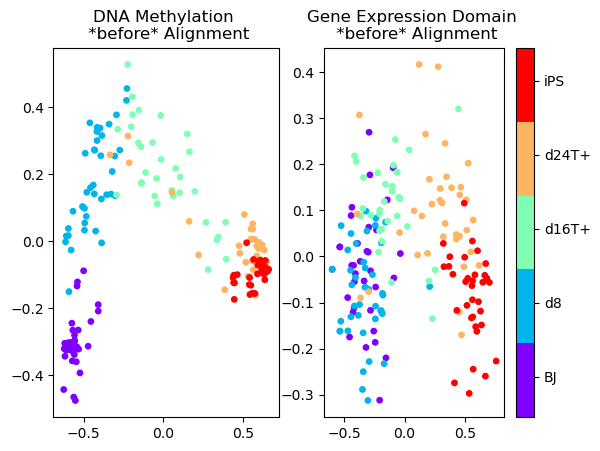

In [9]:
#Visualization of the cell type clusters in original domains *before* alignment
fig, (ax1, ax2)= plt.subplots(1,2)

fig1= ax1.scatter(originalX_pca[:,0], originalX_pca[:,1], c=cellTypes_rna, s=15, cmap=colormap)
ax1.set_title("DNA Methylation \n *before* Alignment")

fig2= ax2.scatter(originaly_pca[:,0], originaly_pca[:,1],  c=cellTypes_methyl, s=15, cmap=colormap)
ax2.set_title("Gene Expression Domain \n *before* Alignment")

cbar=fig.colorbar(fig2)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(["BJ", "d8", "d16T+", "d24T+", "iPS"]) #cell-type labels